# 1.COVID-19 DEATHS ESTIMATION

## Introduction

The covid-19 pandemy has been a world-wide health crises that unfortunately affected all of us. 
Therefore, in this project, we will use covid-19 data that was acquired from Kaggle (https://www.kaggle.com/datasets/harshghadiya/covid-19-country-statistics-dataset) in order to predict the total deaths worldwide given the total covid-19 cases.   
To do this prediction, we will use a Linear regression trained model because it is a type of regression algorithm used for predicting continuous numeric values.

## Imports and data visualization

In [23]:
import pandas as pd
import os
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.impute import SimpleImputer

In [10]:

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin

In [11]:
#If we read the dataset witout processing, we get an error that indicates that there are more fields 
#in line 2 of the csv file than expected. One way to fix this would be to manually check the csv file and 
#ensure that each row has exactly 14 fields. However, I made this code to automate the process: 


#This script reads in the covid19.csv file, checks the number of fields in each row, and removes any extra fields. 
#It then writes the cleaned data to a new file called covid19_cleaned.csv. 

import csv

# Open the csv file
with open('datasets/covid19.csv', 'r') as f:
    reader = csv.reader(f)
    header = next(reader)  # skip the header row
    rows = []
    for row in reader:
        # Check the number of fields in the row
        if len(row) == 14:
            rows.append(row)
        else:
            # Remove any extra fields
            rows.append(row[:14])

# Write the cleaned data to a new file
with open('datasets/covid19_cleaned.csv', 'w', newline='') as f:
    writer = csv.writer(f)
    writer.writerow(header)
    writer.writerows(rows)


In [13]:
df = pd.read_csv('datasets/covid19_cleaned.csv')
df.head()

,Number,Country,Total Cases,New Cases,Total Deaths,New Deaths,Total Recovered,Active cases,Serious_Critical,Total Cases Per 1m Pop,Deaths Per 1m Pop,Total Tests,Tests Per 1m Pop,Population
0,1,USA,"106,613,321","+1,809","1,159,697",35.0,"104,533,271","920,353","1,392","318,434","3,464","1,176,758,558","3,514,755","334,805,269"
1,2,India,"44,924,811",NaN,"531,424",NaN,"44,335,977","57,410",NaN,"31,938",378,"925,077,322","657,654","1,406,631,776"
2,3,France,"39,974,426","+6,609","166,425",NaN,"39,669,392","138,609",869,"609,510","2,538","271,490,188","4,139,547","65,584,518"
3,4,Germany,"38,400,766",NaN,"172,882",NaN,"38,189,800","38,084",NaN,"457,786","2,061","122,332,384","1,458,359","83,883,596"
4,5,Brazil,"37,449,418",NaN,"701,494",NaN,"36,249,161","498,763",NaN,"173,897","3,257","63,776,166","296,146","215,353,593"


## Data preparation

Since we already know that we are going to use the Linear regression algorithm, there are a few data processing steps recommended to use in order to have an accurate and robust linear regression model for our project. The main ones are:

-Data Cleaning: Remove or impute missing or null values, remove duplicate records, and handle outliers.

-Feature Selection: Select the relevant features that are predictive of the target variable (in our case we will ony take into consideration the "Total Cases" and "Total Deaths" features). 

-Feature Scaling: Linear regression works better when the input features are on the same scale. Therefore, it is recommended to apply feature scaling to the input features such as standardization or normalization.

-Handling Categorical Variables: Convert categorical variables into numerical values using techniques such as one-hot encoding, label encoding, or binary encoding (in our case it won't be necessary).

-Train-Test Split: Split the data into training and testing datasets. The training dataset is used to train the linear regression model, and the testing dataset is used to evaluate the performance of the model.


In [73]:
df2 = df.loc[:, ["Total Cases", "Total Deaths"]] #We only select these two columns

In [74]:
#Python detects the numbers of the dataframes as strings but they are numbers in reality. Here's how we change it:
df2["Total Cases"] = df2["Total Cases"].replace(",", "", regex=True).astype(float)
df2["Total Deaths"] = df2["Total Deaths"].replace(",", "", regex=True).astype(float)

A **transformer** is a class in scikit-learn that takes an input dataset and transforms it into an output dataset. Transformers are typically used to process and clean data, convert categorical variables to numerical ones, normalize or scale numerical variables, or any other necessary data transformation to prepare the data for modeling. In this case, we will build a personalized transformer to delete null values and scale the data. 

In [75]:
# Transformer created to delete those rows with null values
from sklearn.base import BaseEstimator, TransformerMixin

class DeleteNanRows(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        return X.dropna()

# Transformer created to scale the selected columns
class CustomScaler(BaseEstimator, TransformerMixin):
    def __init__(self, attributes):
        self.attributes = attributes
    def fit(self, X, y=None):
        return self  # nothing else to do
    def transform(self, X, y=None):
        X_copy = X.copy()
        scale_attrs = X_copy[self.attributes]
        robust_scaler = RobustScaler()
        X_scaled = robust_scaler.fit_transform(scale_attrs)
        X_scaled = pd.DataFrame(X_scaled, columns=self.attributes, index=X_copy.index)
        for attr in self.attributes:
            X_copy[attr] = X_scaled[attr]
        return X_copy

On the other hand, a **pipeline** is a sequence of one or more transformers and a final estimator that are used to process data and train a machine learning model. Custom pipelines allow for the combination of different transformers and a final estimator into an ordered sequence of steps, making it easier to automate the modeling process. Like transformers, custom pipelines are also used to process and transform input data, but they also include a machine learning model as part of the process.In this, case, we will build a personalized pipeline to execute the 2 transformers created before. 

In [76]:
#This pipeline applies the transformators and saves the result in X_transformed. 

from sklearn.pipeline import Pipeline

pipeline = Pipeline([    ('delete_nan_rows', DeleteNanRows()),    ('custom_scaler', CustomScaler(attributes=['Total Cases', 'Total Deaths']))
])

X_transformed = pipeline.fit_transform(df2)

In [77]:
X_transformed.head(10) #Here we can see the result of the data after the transformations and processing done. 

,Total Cases,Total Deaths
0,81.667634,74.195971
1,34.310313,33.920124
2,30.509979,10.521628
3,29.301904,10.935558
4,28.571569,44.822572
5,25.685170,4.626601
6,23.719535,2.061926
7,19.601789,12.006122
8,18.673206,14.080645
9,17.351023,25.380227


In [78]:
#We create a function to divide the data

def train_val_test_split(df, rstate=42, shuffle=True, stratify=None):
    strat = df[stratify] if stratify else None
    train_set, test_set = train_test_split(
        df, test_size=0.4, random_state=rstate, shuffle=shuffle, stratify=strat)
    strat = test_set[stratify] if stratify else None
    val_set, test_set = train_test_split(
        test_set, test_size=0.5, random_state=rstate, shuffle=shuffle, stratify=strat)
    return (train_set, val_set, test_set)

In [79]:
train_set, val_set, test_set = train_val_test_split(X_transformed)

In [80]:
print("The length of the training set is:", len(train_set))
print("The length of the validation set is:", len(val_set))
print("The length of the test set is:", len(test_set))

The length of the training set is: 128
The length of the validation set is: 43
The length of the test set is: 43


In [53]:
# We divide the data and separe it from the label:

X_df = X_transformed.drop("Total Deaths", axis=1)
y_df = X_transformed["Total Deaths"].copy()

X_train = train_set.drop("Total Deaths", axis=1)
y_train = train_set["Total Deaths"].copy()

X_val = val_set.drop("Total Deaths", axis=1)
y_val = val_set["Total Deaths"].copy()

X_test = test_set.drop("Total Deaths", axis=1)
y_test = test_set["Total Deaths"].copy()



## Algorithm training

As it was mentioned before, we will use the Linear regression to train our model. It is a type of regression algorithm used for predicting continuous numeric values.

In [81]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

In [82]:
#We train the model with the training set
regressor = LinearRegression()
regressor.fit(X_train, y_train)

LinearRegression()

In [83]:
y_pred = regressor.predict(X_test)

In [61]:
# theta 0 parameter of the equation
regressor.intercept_

-0.14519636518058165

In [84]:
# theta 1 parameter of the equation
regressor.coef_

array([0.81975565])

In [85]:
# Prdiction for the minimum and maximum value from the trained dataset
X_min_max = np.array([[X_transformed["Total Cases"].min()], [X_transformed["Total Cases"].max()]])
y_train_pred = regressor.predict(X_min_max)

C:\Users\Ihona\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


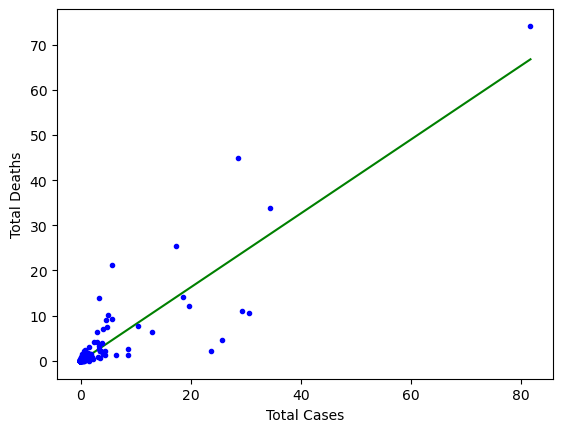

In [86]:
# Graphic representation of the hypothesis function created
plt.plot(X_min_max, y_train_pred, "g-")
plt.plot(X_transformed['Total Cases'], X_transformed['Total Deaths'], "b.")
plt.xlabel("Total Cases")
plt.ylabel("Total Deaths")
plt.show()

In [88]:
#We can evaluate our results by calculating this parameters:

print("Mean Square Error: ", mean_squared_error(y_test, y_pred))
print("R2 coefficient: ", r2_score(y_test, y_pred))

#The parameters seem reasonable

Mean Square Error:  3.64104158378124
R2 coefficient:  0.7555390593455421


## Prediction of a new example

Now that we have our model trained, we can predict the total deaths from the total covid cases. This could be useful in order to estimate how many deaths there would be if infections increased. We have to remember that our data has been scaled. 

In [90]:
X_new = np.array([[75]]) #Let's suppose the total covid cases increase up to 75
y_pred = regressor.predict(X_new) #y_pred returns us the total deaths with an increase of 75 covid cases
print(y_pred)

[61.3364772]


C:\Users\Ihona\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


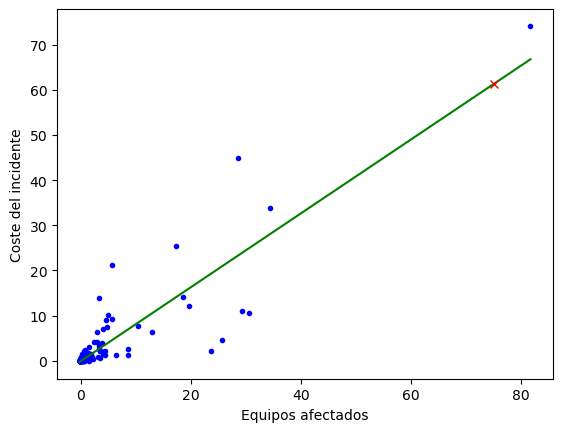

In [94]:
#Let's plot the prediction

plt.plot(X_transformed['Total Cases'], X_transformed['Total Deaths'], "b.")
plt.plot(X_min_max, y_train_pred, "g-")
plt.plot(X_new, y_pred, "rx")
plt.xlabel("Equipos afectados")
plt.ylabel("Coste del incidente")
plt.show()

## Conclusions

In this exercise we have realized the power of a basic machine learning algorithm such as linear regression for prediction. In this particular case, the prediction of the deaths due to the increase of covid-19 cases could be crutial for applying social-distancing or other restrictons that could save people's lives. 